In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import coloring
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit.library import QAOAAnsatz
import time
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import time
import logging
import sys

# Configure logging for Jupyter
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)  # Output to notebook cell
    ]
)

logger = logging.getLogger(__name__)
logging.getLogger('qiskit').setLevel(logging.WARNING)


In [2]:
node_start = 4
node_end = 5
max_color_possible = 4
do_simulate = False

In [3]:

QiskitRuntimeService.delete_account()
#
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='f03a9c375d44f0b93a1505bf31d0f42e7a39aa8360404f2d01633e04f461e8da12fd9a091e2eff4b8b10c73d98228baaba6adbcf7cd9e1a1bee6b20b99b78605', overwrite=True)

# QiskitRuntimeService.save_account(token="tEH4qCQyK2sfiXgHyL4vOxku8LUcqSLa0lwg_0zzKS8O", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/0d5f2945f5c44fd6a69d8a9dd034808c:2e832f3b-b7a7-466c-b735-53a9ed77d94b::", overwrite=True)

In [4]:
service = QiskitRuntimeService()
#
for backend in service.backends(simulator=False, operational=True):
    logger.info(f"{backend.name} – {backend.configuration().num_qubits} qubits")

/var/folders/j_/6x8b_dk9253_tf1dd1vvw84r0000gn/T/ipykernel_3663/3343055937.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


2025-06-24 18:24:00,932 - __main__ - INFO - ibm_brisbane – 127 qubits
2025-06-24 18:24:00,934 - __main__ - INFO - ibm_sherbrooke – 127 qubits


In [5]:
def generate_graph(num_nodes, edge_prob=0.5, seed=32):
    return nx.erdos_renyi_graph(num_nodes, edge_prob, seed=seed)

In [6]:
import numpy as np

# QUBO conversion and Hamiltonian construction
def create_qubo_hamiltonian(graph, num_colors):
    num_nodes = graph.number_of_nodes()
    Q = np.zeros((num_nodes * num_colors, num_nodes * num_colors))
    for i in range(num_nodes):
        for c in range(num_colors):
            Q[i * num_colors + c, i * num_colors + c] -= 1
            for cp in range(c + 1, num_colors):
                Q[i * num_colors + c, i * num_colors + cp] += 2
    for i, j in graph.edges():
        for c in range(num_colors):
            Q[i * num_colors + c, j * num_colors + c] += 1
    Q = 0.5 * (Q + Q.T)
    linear = np.diag(Q)
    quadratic = Q - np.diag(linear)
    h = {i: linear[i] for i in range(len(linear))}
    J = {(i, j): quadratic[i, j] for i in range(len(linear)) for j in range(i + 1, len(linear)) if quadratic[i, j] != 0}
    
    pauli_list = []
    for (i, j), weight in J.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        z_p[j] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    for i, weight in h.items():
        z_p = np.zeros(len(linear), dtype=bool)
        x_p = np.zeros(len(linear), dtype=bool)
        z_p[i] = True
        pauli_list.append((Pauli((z_p, x_p)), weight))
    hamiltonian = sum([SparsePauliOp.from_list([(pauli.to_label(), weight)]) for pauli, weight in pauli_list])
    
    return hamiltonian

In [7]:
def is_valid_coloring(graph, coloring):
    """Return True if no adjacent vertices share the same color and all nodes are assigned valid colors."""
    for u, v in graph.edges():
        if coloring[u] == coloring[v]:
            return False

    if len(set(coloring)) > max_color_possible:
        return False

    return True


In [8]:
def extract_relevant_bits(full_counts, layout, num_logical_qubits):
    """Extract only the bits corresponding to logical qubits from full measurement results"""
    extracted_counts = {}

    for bitstring, count in full_counts.items():
        # Extract only the bits we care about based on the layout
        relevant_bits = ""
        for i in range(num_logical_qubits):
            # Get the physical qubit index for logical qubit i
            physical_qubit = layout.initial_layout[i]
            # Extract the bit at that position (bitstrings are reversed in Qiskit)
            bit_index = len(bitstring) - 1 - physical_qubit._index
            relevant_bits += bitstring[bit_index]

        # Accumulate counts for the same relevant bitstring
        if relevant_bits in extracted_counts:
            extracted_counts[relevant_bits] += count
        else:
            extracted_counts[relevant_bits] = count

    return extracted_counts

In [9]:
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_aer.primitives import SamplerV2 as aersampler
import time

from qiskit_aer import AerSimulator

def run_qaoa(graph, cost_hamiltonian, p, max_iter, shots):

    # Create QAOA ansatz
    quantum_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
    if do_simulate:
        backend_for_simulator = service.least_busy(
            operational=True, simulator=False, min_num_qubits=graph.number_of_nodes(),
        )
        _backend = AerSimulator.from_backend(backend_for_simulator)
    else:
        _backend = service.least_busy(
            operational=True, simulator=False, min_num_qubits=graph.number_of_nodes(),
        )

    logger.info(_backend)

    # Transpile circuit and get the mapping
    pm = generate_preset_pass_manager(backend=_backend, optimization_level=3, seed_transpiler=42)
    isa_circuit = pm.run(quantum_circuit)
    layout = isa_circuit.layout
    num_logical_qubits = quantum_circuit.num_qubits

    # Initialize estimator
    estimator = Estimator(_backend)
    estimator.options.resilience_level = 0
    estimator.options.default_shots = 500

    objective_func_vals = [] # Global variable
    def cost_func_estimator(params, ansatz, hamiltonian, _estimator):
        isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

        pub = (ansatz, isa_hamiltonian, params)
        job = _estimator.run([pub])

        results = job.result()[0]
        cost = results.data.evs
        objective_func_vals.append(cost)
        return cost

    # Initialize parameters randomly
    num_params = quantum_circuit.num_parameters
    initial_params = np.random.uniform(-np.pi/6, np.pi/6, num_params)

    optimization_options = {
        'maxiter': max_iter,
        'catol': 1e-6,
        'disp': True
    }

    result = minimize(
        cost_func_estimator,
        initial_params,
        args=(isa_circuit, cost_hamiltonian, estimator),
        method='COBYLA',
        options=optimization_options
    )

    sampler = Sampler(_backend)
    optimal_circuit = isa_circuit.assign_parameters(result.x)
    optimal_circuit.measure_active()

    final_job = sampler.run([(optimal_circuit, None)])
    final_result = final_job.result()

    full_counts = final_result[0].data.meas.get_counts()
    final_counts = extract_relevant_bits(full_counts, layout, num_logical_qubits)

    best_bitstring = max(final_counts, key=final_counts.get)

    if not do_simulate:
        real_execution_time = final_result.metadata['execution']['execution_spans'].duration
        return real_execution_time, best_bitstring, final_counts
    else:
        return 0, best_bitstring, final_counts


In [10]:
def decode_binary_coloring(bitstring, num_vertices, num_colors):
    """
    Decodes a binary-encoded QAOA bitstring into color assignments for each vertex.
    Returns:
        coloring (list): List of assigned color indices for each vertex.
        valid (bool): True if all assignments are valid, False otherwise.
    """
    bits_per_node = int(len(bitstring)/num_vertices)
    coloring = []
    valid = True

    for v in range(num_vertices):
        start = v * bits_per_node
        end = start + bits_per_node
        color_bits = bitstring[start:end]
        color_idx = int(color_bits, 2)
        coloring.append(color_idx)
    return coloring, valid


In [11]:

def run_qaoa_with_retry(graph, max_colors, p, max_iter, shots):
    num_vertices = len(graph.nodes)
    _iter = 0
    for num_colors in range(2, max_colors + 1):

        logger.info(f"\n +++++++++++++++++++ Node: {num_vertices}, Color: +++++++++++++++++++  {num_colors}")

        cost_hamiltonian = create_qubo_hamiltonian(graph, num_colors)
        real_execution_time, _best_bitstring, _final_counts  = run_qaoa(
            graph=graph, p=p, max_iter=max_iter, shots=shots, cost_hamiltonian=cost_hamiltonian
        )
        print(f"best bitstring is ----- {_best_bitstring}")
        _coloring, valid = decode_binary_coloring(_best_bitstring, num_vertices, num_colors)
        print(f"best coloring is ----- {_coloring}")
        if valid and is_valid_coloring(graph, _coloring):
            return num_vertices, num_colors, real_execution_time, _coloring, _iter
        else:
            _iter+=1

        # Optionally: logger.info diagnostic info
        # logging.error(f"Attempt with {num_colors} colors failed. Coloring: {_coloring}, Valid: {valid}")

    raise ValueError(f"No valid coloring found with ≤ {max_colors} colors")


In [12]:
# def dsatur_coloring(graph):
#     coloring = {}
#     saturation_degrees = {node: 0 for node in graph.nodes()}
#     available_colors = [True] * len(graph.nodes())
#     iterations = 0
#     while len(coloring) < len(graph.nodes()):
#         iterations += 1
#         uncolored_nodes = [node for node in graph.nodes() if node not in coloring]
#         max_saturation = -1
#         selected_node = None
#         for node in uncolored_nodes:
#             if saturation_degrees[node] > max_saturation:
#                 max_saturation = saturation_degrees[node]
#                 selected_node = node
#             elif saturation_degrees[node] == max_saturation:
#                 if selected_node is None or graph.degree[node] > graph.degree[selected_node]:
#                     selected_node = node
#         neighbor_colors = {coloring[neighbor] for neighbor in graph.neighbors(selected_node) if neighbor in coloring}
#         for color in range(len(available_colors)):
#             if color not in neighbor_colors:
#                 coloring[selected_node] = color
#                 break
#         for neighbor in graph.neighbors(selected_node):
#             if neighbor not in coloring:
#                 saturation_degrees[neighbor] += 1
#     return coloring, iterations

In [13]:
# def run_dsatur(graph):
#     start_time = time.time()
#     _, classical_iter = dsatur_coloring(graph)
#     classical_time = time.time() - start_time
#     return classical_time, classical_iter


In [14]:

import json
import os
from typing import List, Dict, Any, Optional

def update_experiment_data(
    num_node: int,
    data_key: str,
    data_value: str,
    filename: str = 'experiment_data.json'
) -> Dict[str, Any]:

    experiment_data = _load_experiment_data(filename)
    num_nodes_str = str(num_node)

    # Create entry for this number of nodes if it doesn't exist
    if num_nodes_str not in experiment_data["experiment_data"]:
        experiment_data["experiment_data"][num_nodes_str] = {}

    # Update the data
    experiment_data["experiment_data"][num_nodes_str][data_key] = data_value

    # Save updated data back to JSON file
    _save_experiment_data(experiment_data, filename)
    return experiment_data


def _load_experiment_data(filename: str) -> Dict[str, Any]:
    if os.path.exists(filename):
        try:
            with open(filename, 'r') as f:
                experiment_data = json.load(f)
        except (json.JSONDecodeError, IOError) as e:
            experiment_data = {"experiment_data": {}}
    else:
        experiment_data = {"experiment_data": {}}

    if "experiment_data" not in experiment_data:
        experiment_data["experiment_data"] = {}
    return experiment_data


def _save_experiment_data(experiment_data: Dict[str, Any], filename: str) -> None:
    try:
        with open(filename, 'w') as f:
            json.dump(experiment_data, f, indent=2)
    except IOError as e:
        error_msg = f"Error saving to {filename}: {e}"
        raise IOError(error_msg)


In [15]:
# Initialize lists to store the results
real_quantum_times = []
num_nodes_list = []

In [16]:
import time
import matplotlib.pyplot as plt

def plot_coloring(graph, coloring, num_colors):
    pos = nx.spring_layout(graph)
    cmap = plt.get_cmap('tab20', num_colors)
    node_colors = [cmap(color) if color != -1 else (0.8, 0.8, 0.8) for color in coloring]
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.title(f'Graph Coloring with {num_colors} colors')
    plt.show()

In [17]:
def remap_colors(coloring):
    unique_colors = sorted(set(coloring) - {-1})
    color_map = {color: idx for idx, color in enumerate(unique_colors)}
    remapped = [color_map[c] if c != -1 else -1 for c in coloring]
    return remapped, len(unique_colors)

In [18]:
def plot_coloring(graph, coloring, num_colors):
    import networkx as nx
    pos = nx.spring_layout(graph)
    cmap = plt.get_cmap('tab20', num_colors)
    node_colors = [cmap(color) if color != -1 else (0.8, 0.8, 0.8) for color in coloring]
    nx.draw(graph, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
    plt.title(f'Graph Coloring with {num_colors} colors')
    plt.show()

In [19]:
import networkx as nx
from collections import deque

def edge_bfs_depth(graph, edge):
    """Compute BFS depth starting from an edge (as a tuple of nodes)."""
    visited_edges = set()
    queue = deque([(edge, 0)])
    max_depth = 0
    while queue:
        (u, v), depth = queue.popleft()
        if (u, v) in visited_edges or (v, u) in visited_edges:
            continue
        visited_edges.add((u, v))
        max_depth = max(max_depth, depth)
        # Explore all edges adjacent to u or v
        for neighbor in set(graph.neighbors(u)).union(graph.neighbors(v)):
            if neighbor != u and neighbor != v:
                for node in (u, v):
                    if graph.has_edge(node, neighbor):
                        queue.append(((node, neighbor), depth + 1))
    return max_depth

In [20]:
def compute_c_depth(graph):
    """Compute the covering depth (c-depth) for the graph."""
    max_bfs_depth = 0
    for edge in graph.edges():
        depth = edge_bfs_depth(graph, edge)
        max_bfs_depth = max(max_bfs_depth, depth)
    return max_bfs_depth

In [21]:
def sweep_qaoa_p_levels(graph, max_colors, max_iter, shots):


    start_time = time.perf_counter()
    try:
        p_level = 3
        logger.info(f"\nRunning QAOA with p={p_level}, Node: {graph.number_of_nodes()}, Color: {shots}")

        num_vertices, num_colors, real_execution_time, _coloring, found_after = run_qaoa_with_retry(
            graph, max_colors=max_colors, p=p_level, max_iter=max_iter, shots=shots
        )

        end_time = time.perf_counter()
        total_time = end_time - start_time

        remapped_coloring, actual_colors_used = remap_colors(_coloring)

        update_experiment_data(num_vertices, "real_execution_time", str(real_execution_time))
        update_experiment_data(num_vertices, "found_after", str(found_after))
        update_experiment_data(num_vertices, "total_time", str(total_time))
        update_experiment_data(num_vertices, "p_level", str(p_level))
        update_experiment_data(num_vertices, "no_of_colors_allowed", str(num_colors))
        update_experiment_data(num_vertices, "no_of_colors_actually_used", str(actual_colors_used))
        update_experiment_data(num_vertices, "remapped_coloring", str(remapped_coloring))

        # Plot the solution for each p
        plot_coloring(graph, remapped_coloring, actual_colors_used)

    except ValueError as e:
        end_time = time.perf_counter()
        total_time = end_time - start_time
        logger.info(f"Failed for p={p_level}: {e} (Time: {total_time:.4f} s)")



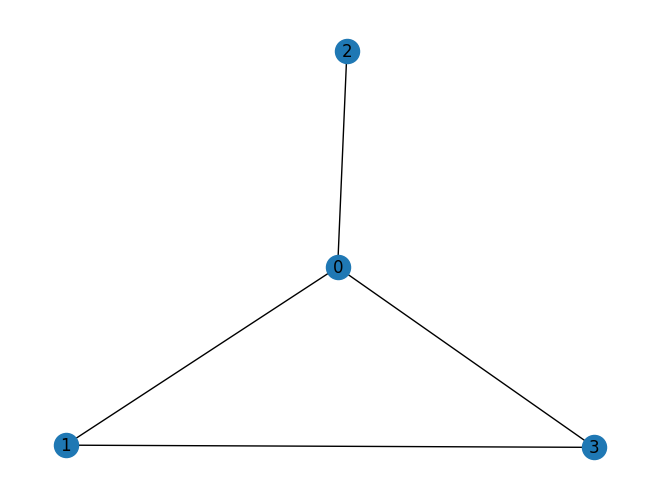

2025-06-24 18:24:01,251 - __main__ - INFO - 
Running QAOA with p=3, Node: 4, Color: 1024
2025-06-24 18:24:01,251 - __main__ - INFO - 
 +++++++++++++++++++ Node: 4, Color: +++++++++++++++++++  2
2025-06-24 18:24:03,315 - __main__ - INFO - <IBMBackend('ibm_brisbane')>


base_primitive._run:INFO:2025-06-24 18:24:06,701: Submitting job using options {'options': {'default_shots': 500}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
/Users/utkarshsharma/PycharmProjects/QAOA_vs_classical/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)
base_primitive._run:INFO:2025-06-24 18:26:23,759: Submitting job using options {'options': {'default_shots': 500}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
base_primitive._run:INFO:2025-06-24 18:26:34,334: Submitting job using options {'options': {'default_shots': 500}, 'version': 2, 'support_qiskit': True, 'resilience_level': 0}
base_primitive._run:INFO:2025-06-24 18:26:46,026: Submitting job using opti


   Normal return from subroutine COBYLA

   NFVALS =   59   F =-4.040000E-01    MAXCV = 0.000000E+00
   X = 1.033430E+00  -1.815332E-01  -2.538451E-01  -5.130342E-02   3.250240E-01
       7.851961E-02
best bitstring is ----- 11000001
best coloring is ----- [3, 0, 0, 1]


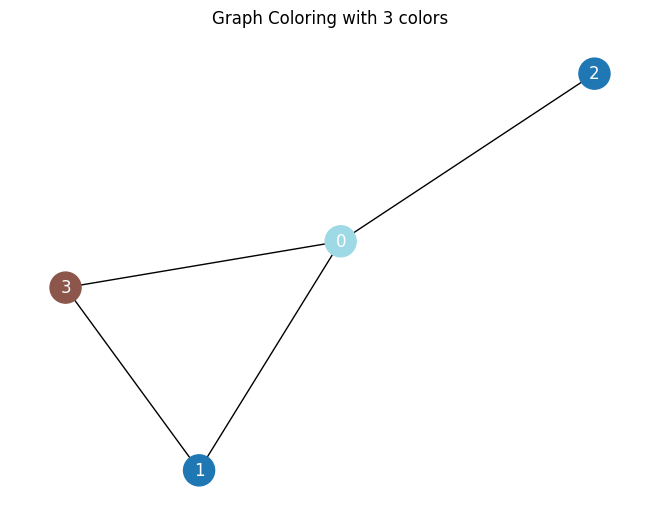

In [22]:
for num_nodes in range(node_start, node_end):
    G = generate_graph(num_nodes=num_nodes, seed=32)
    nx.draw(G, with_labels=True)
    plt.show()
    sweep_qaoa_p_levels(G, max_colors=max_color_possible, max_iter=100, shots=1024)
